# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
    
_set_env("GROQ_API_KEY")

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-qwq-32b")
llm.invoke(messages)

AIMessage(content='\n<think>\nOkay, the user is interested in learning about ocean mammals beyond whales. They already know about whales, so I need to highlight others. Let me start by recalling the main groups of marine mammals. There are whales, dolphins, and porpoises, which are cetaceans. But they already know whales, so maybe focus on the other cetaceans like dolphins and porpoises first.\n\nThen there are the pinnipeds: seals, sea lions, and walruses. These are important. Maybe mention their differences, like how they move on land. Also, sirenians, like manatees and dugongs, which are less commonly known. They\'re herbivores, so that\'s a unique trait.\n\nPolar bears are sometimes included, but they\'re semi-aquatic. Maybe mention that but clarify their classification. Then there are the smaller ones like the vaquita, the smallest porpoise, which is endangered. Narwhals are interesting too, with the tusk.\n\nI should list them in categories: cetaceans, pinnipeds, sirenians, and o

We can run our chat model in a simple graph with `MessagesState`.

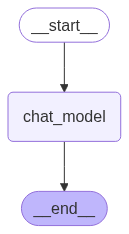

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.graph import MessagesState

def chat_model(state: MessagesState): 
    return {"messages": llm.invoke(state["messages"])}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================


<think>
Okay, the user is interested in ocean mammals beyond whales. I should make sure to cover a variety of species, not just the well-known ones. Let me think about different groups like dolphins, porpoises, seals, sea lions, walruses, manatees, and maybe some less common ones like dugongs or even the lesser-known ones like the narwhal or beluga.

I need to explain each briefly but informatively. Maybe start with the main categories: cetaceans (whales, dolphins, porpoises), pinnipeds (seals, sea lions, walruses), and sirenians (manatees and dugongs). Including some unique species within each group would be he

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

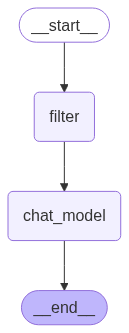

In [11]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import StateGraph

def filter_message(state: MessagesState) -> MessagesState:
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("filter", filter_message)
builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
messages = [AIMessage("Hi!", id="1", name= "Bot")]
messages.append(HumanMessage("Hello, What's up?", id="2", name="Kunal"))
messages.append(AIMessage("All good!! How can I help you", id="3", name="Bot"))
messages.append(HumanMessage("what are traditions of Rajasthan?", id="4", name="Kunal"))

output=graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

All good!! How can I help you
================================ Human Message =================================
Name: Kunal

what are traditions of Rajasthan?
================================== Ai Message ==================================


<think>
Okay, the user is asking about the traditions of Rajasthan. Let me start by recalling what I know about Rajasthan. It's a state in India, known for its rich culture and history. I need to cover the main traditions, so I should think about festivals, art forms, clothing, and social customs.

First, festivals. Rajasthan has vibrant festivals like Teej, Gangaur, and Desert Festival. Teej is for monsoon and women's well-being, right? Gangaur is celebrated for goddess Gauri. Then there's the Elephant Festival during Holi, which might tie into the Desert Festival in Jaisalmer. I should mention these with some details.

Next, art and music. The Rajasthani fo

In [ ]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("What are the famous places of Rajasthan",id="6",name="Kunal"))

[AIMessage(content='Hi!', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content="Hello, What's up?", additional_kwargs={}, response_metadata={}, name='Kunal', id='2'),
 AIMessage(content='All good!! How can I help you', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='what are traditions of Rajasthan?', additional_kwargs={}, response_metadata={}, name='Kunal', id='4'),
 AIMessage(content='\n<think>\nOkay, the user is asking about the traditions of Rajasthan. Let me start by recalling what I know about Rajasthan. It\'s a state in India, known for its rich culture and history. I need to cover the main traditions, so I should think about festivals, art forms, clothing, and social customs.\n\nFirst, festivals. Rajasthan has vibrant festivals like Teej, Gangaur, and Desert Festival. Teej is for monsoon and women\'s well-being, right? Gangaur is celebrated for goddess Gauri. Then there\'s the Elephant Festival during Hol

In [30]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi!
================================ Human Message =================================
Name: Kunal

Hello, What's up?
================================== Ai Message ==================================
Name: Bot

All good!! How can I help you
================================ Human Message =================================
Name: Kunal

what are traditions of Rajasthan?
================================== Ai Message ==================================


<think>
Okay, the user is asking about the traditions of Rajasthan. Let me start by recalling what I know about Rajasthan. It's a state in India, known for its rich culture and history. I need to cover the main traditions, so I should think about festivals, art forms, clothing, and social customs.

First, festivals. Rajasthan has vibrant festivals like Teej, Gangaur, and Desert Festival. Teej is for monsoon and women's well-being, right? Gangaur is celebr

In [31]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================


<think>
Okay, the user is asking about the traditions of Rajasthan. Let me start by recalling what I know about Rajasthan. It's a state in India, known for its rich culture and history. I need to cover the main traditions, so I should think about festivals, art forms, clothing, and social customs.

First, festivals. Rajasthan has vibrant festivals like Teej, Gangaur, and Desert Festival. Teej is for monsoon and women's well-being, right? Gangaur is celebrated for goddess Gauri. Then there's the Elephant Festival during Holi, which might tie into the Desert Festival in Jaisalmer. I should mention these with some details.

Next, art and music. The Rajasthani folk music with instruments like the been and dholak comes to mind. The Bhopa tradition with the kamayacha might be another point. Also, folk dances like Ghoomar and Kalbeliya, especially the latter's association with snake charmers. Mentioning the art

## Filtering messages
If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

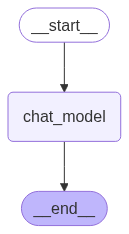

In [40]:
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("Tell me more about that Rajasthan.", id="7", name="Kunal"))

In [48]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi!
================================ Human Message =================================
Name: Kunal

Hello, What's up?
================================== Ai Message ==================================
Name: Bot

All good!! How can I help you
================================ Human Message =================================
Name: Kunal

what are traditions of Rajasthan?
================================== Ai Message ==================================


<think>
Okay, the user is asking about the traditions of Rajasthan. Let me start by recalling what I know about Rajasthan. It's a state in India, known for its rich culture and history. I need to cover the main traditions, so I should think about festivals, art forms, clothing, and social customs.

First, festivals. Rajasthan has vibrant festivals like Teej, Gangaur, and Desert Festival. Teej is for monsoon and women's well-being, right? Gangaur is celebr

In [49]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi!
================================ Human Message =================================
Name: Kunal

Hello, What's up?
================================== Ai Message ==================================
Name: Bot

All good!! How can I help you
================================ Human Message =================================
Name: Kunal

what are traditions of Rajasthan?
================================== Ai Message ==================================


<think>
Okay, the user is asking about the traditions of Rajasthan. Let me start by recalling what I know about Rajasthan. It's a state in India, known for its rich culture and history. I need to cover the main traditions, so I should think about festivals, art forms, clothing, and social customs.

First, festivals. Rajasthan has vibrant festivals like Teej, Gangaur, and Desert Festival. Teej is for monsoon and women's well-being, right? Gangaur is celebr

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

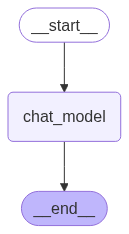

In [89]:
from langchain_core.messages import trim_messages

def chat_model(state: MessagesState):
    messages =  trim_messages(
        state["messages"],
        max_tokens= 100,
        strategy="last",
        token_counter=llm,
        allow_partial=False
        
    )
    return {"messages": [llm.invoke(messages)]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [87]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("Why Jaipur is known as Pink city?", id="9", name="Kunal"))

In [88]:
trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=llm,
    # allow_partial=True
)

[HumanMessage(content='Why Jaipur is known as Pink city?', additional_kwargs={}, response_metadata={}, name='Kunal', id='9')]

In [90]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi!
================================ Human Message =================================
Name: Kunal

Hello, What's up?
================================== Ai Message ==================================
Name: Bot

All good!! How can I help you
================================ Human Message =================================
Name: Kunal

what are traditions of Rajasthan?
================================== Ai Message ==================================


<think>
Okay, the user is asking about the traditions of Rajasthan. Let me start by recalling what I know about Rajasthan. It's a state in India, known for its rich culture and history. I need to cover the main traditions, so I should think about festivals, art forms, clothing, and social customs.

First, festivals. Rajasthan has vibrant festivals like Teej, Gangaur, and Desert Festival. Teej is for monsoon and women's well-being, right? Gangaur is celebr